In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from skimage.color import label2rgb
from skimage.measure import regionprops
import os

In [2]:
if not os.path.exists('frames'):
        os.mkdir('frames')

# Adjacency Matrix

In [ ]:
# Colour Adjacency matrix derived from
# http://fs.unm.edu/IJMC/BoundsForTheLargestColorEigenvalue.pdf
def adjMatrix(img):
    # Initialize the adjacency matrix to be 0
    row, col, _ = img.shape
    A = np.zeros([row*col,row*col], dtype=int)
    i = 0
    # iterate through each pixel in the image
    for r in range(row):
        for c in range(col):
            px_clr_R = img[r,c,0]
            px_clr_G = img[r,c,1]
            px_clr_B = img[r,c,2]
            # find all pixels that have the same colour 
            # set those values to -1 in the adjacency matrix
            R = (img[:,:,0] == px_clr_R).reshape(-1)
            G = (img[:,:,1] == px_clr_G).reshape(-1)
            B = (img[:,:,2] == px_clr_B).reshape(-1)
            A[i,:] = -1 * R*G*B
            
            # check for adjacent pixels according to 8-connected pixel graph
            # http://www.cb.uu.se/~filip/ImageProcessingUsingGraphs/LectureNotes/Lecture1.pdf
            for r_iter in([-1, 0, 1]):
                for c_iter in([-1, 0, 1]):
                    # calculate current position
                    r_pos = r + r_iter
                    c_pos = c + c_iter
                    # skip if current position is corner
                    if (c_pos) < 0 or (r_pos) < 0 or \
                    (c_pos) > (col-1) or  (r_pos) > (row-1):    
                        pass
                    else:
                        # check if neighbour is same colour
                        if img[r_pos, c_pos, 0] == px_clr_R and \
                            img[r_pos, c_pos, 1] == px_clr_G and \
                            img[r_pos, c_pos, 2] == px_clr_B:
                            # set the value to 1
                            A[i, r_pos*col + c_pos] = 1
            # increment the row
            i += 1
    return A

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
img_clr = np.zeros([row*col,row*col,3],dtype=int)
img_clr[:,:,0] = 255*(A==1)
img_clr[:,:,1] = 255*(A==0)
img_clr[:,:,2] = 255*(A==-1)
plt.imshow(img_clr)

## Grayscale Case

In [ ]:
img = np.array([[0,  0,  0,0],
                [0,255,255,0],
                [0,255,255,0],
                [0,  0,  0,0]])

In [ ]:
# Colour Adjacency matrix derived from
# http://fs.unm.edu/IJMC/BoundsForTheLargestColorEigenvalue.pdf

# Initialize the adjacency matrix to be 0
row, col = img.shape
A = np.zeros([row*col,row*col], dtype=int)
i = 0
# iterate through each pixel in the image
for r in range(row):
    for c in range(col):
        px_clr = img[r,c]
        # find all pixels that have the same colour 
        # set those values to -1 in the adjacency matrix
        A[i,:] = -1*(img == px_clr).reshape(-1)
        
        # check for adjacent pixels according to 8-connected pixel graph
        # http://www.cb.uu.se/~filip/ImageProcessingUsingGraphs/LectureNotes/Lecture1.pdf
        for r_iter in([-1, 0, 1]):
            for c_iter in([-1, 0, 1]):
                # calculate current position
                r_pos = r + r_iter
                c_pos = c + c_iter
                # skip if current position is corner
                if (c_pos) < 0 or (r_pos) < 0 or \
                (c_pos) > (col-1) or  (r_pos) > (row-1):    
                    pass
                else:
                    # check if neighbour is same colour
                    if img[r_pos, c_pos] == px_clr:
                        # set the value to 1
                        A[i, r_pos*col + c_pos] = 1
        # increment the row
        i += 1

# Edge Detection

In [3]:
from scipy.signal import convolve2d

def Gauss2D(k_x, sigma_x, k_y, sigma_y):
    # Inputs
    # k_x: filter radius along x direction
    # sigma_x: sigma along x direction
    # k_y: filter radius along y direction
    # sigma_y: sigma along y direction

    # Outputs:
    # Guassian Kernel of size (2*k_x + 1) x (2*k_y + 1)

    # Gaussian kernel along x
    radius_x = k_x
    x = np.arange(-radius_x, radius_x + 1)            # Generate X values between -k_x to k_x+1
    kernel_x = np.exp(- x**2 / (2 * sigma_x**2))      # Gaussian  Exponential portion
    kernel_x = np.reshape(kernel_x, [2*k_x + 1, 1])   # Reshape into Column Vector

    # Gaussian kernel along y
    radius_y = k_y
    y = np.arange(-radius_y, radius_y + 1)            # Generate Y values between -k_y to k_y+1
    kernel_y = np.exp(- y**2 / (2 * sigma_y**2))      # Gaussian Exponential portion
    kernel_y = np.reshape(kernel_y, [2*k_y + 1, 1])   # Reshape into Column Vector

    gaussKernel = np.dot(kernel_x, kernel_y.T)        # Outter product of X and Y Gaussian Vectors
    gaussKernel = gaussKernel / gaussKernel.sum()     # Normalize the kernel
    return gaussKernel 

def gradMagnitude(img):
    # Inputs
    # img: image f(x,y)

    # Outputs:
    # Gradient Magnitude g(x,y)

    # x and y high-pass filters
    filter_x = np.array([[-1,0,1],
                         [-2,0,2],
                         [-1,0,1]])
    filter_y = np.array([[-1,-2,-1],
                         [0 , 0, 0], 
                         [1 , 2, 1]])
    
    # Compute Sobel operators
    g_x = convolve2d(img, filter_x, mode='same') 
    g_y = convolve2d(img, filter_y, mode='same') 

    return np.sqrt(np.square(g_x) + np.square(g_y))

def thresholdAlgorithm(img):
    # Inputs
    # img: image gradient g(x,y)

    # Outputs:
    # edge-mapped image E(x,y)

    # 1. compute initial threshold tao_0 of the image
    tao_0 = img.sum() / (img.shape[0]*img.shape[1])

    # 2. Separate g(x,y) into two classes
    m_H = img * (img > tao_0)               # all entries of image greater than threshold
    m_L = img * (img < tao_0)               # all entries of image smaller than threshold

    # 3. Compute average of mL and mH
    m_H_count = (m_H > 0).sum()
    if m_H_count > 0:
       m_H = m_H.sum() / m_H_count 
    m_L_count = (m_L > 0).sum()
    if m_L_count > 0:
       m_L = m_L.sum() / m_L_count 

    # 4. Update threshold value
    tao_i = (m_L + m_H) / 2

    # 5. Loop while threshold difference above epsilon, small
    tao_test = tao_0
    epi = 1e-4
    i = 0
    while np.absolute(tao_i - tao_test) > epi:
        i += 1
        # 2. Separate g(x,y) into two classes
        tao_test = tao_i
        m_H = img * (img > tao_test)        # all entries of image greater than threshold
        m_L = img * (img < tao_test)        # all entries of image smaller than threshold

        # 3. Compute average of mL and mH
        m_H_count = (m_H > 0).sum()
        if m_H_count > 0:
            m_H = m_H.sum() / m_H_count 
        m_L_count = (m_L > 0).sum()
        if m_L_count > 0:
            m_L = m_L.sum() / m_L_count 
  
        # 4. Update threshold value
        tao_i = (m_L + m_H) / 2

    # print('Loop iterations: ', i)
    # print('Threshold: ', tao_i)
    # Return image gradient where value greater than threshold
    return 1*(img > tao_i), tao_i

In [5]:
def CCL(img):
    # Inputs
    # img: edge-mapped image E(x,y)

    # Outputs:
    # labels: modified image of each connected component labelled
    # currlabel: label of the last connected component found within image

    # Initialize label matrix of size w x h
    x, y = img.shape
    labels = np.zeros([x,y], dtype=int)
    queue = []    # Initialize queue as a list
    
    # 1. Start from first pixel, set current label = 0 as there are none labeled yet
    currLabel = 0
    for i in range(x):
        for j in range(y):
            # 3. pop from queue, look at 8 neighbours
            #       if neighbour is foreground (white), not labelled
            #             give currLabel
            #             add to queue
            # Repeat while queue not empty

            # 2. if pixel is foreground (white) and not labelled, label and add to queue
            #    else, (i.e. background (black) or labelled, next)
            if img[i][j] == 255 and labels[i][j] == 0:
                # print(i, j)
                # 4. increment label as new pixel without label is found
                currLabel += 1
                labels[i][j] = currLabel
                queue.append((i,j))
                # 3. Pop element from queue, label neighbours if foreground, add to queue
                #    loop until queue empty 
                while len(queue) > 0:
                    i_pop, j_pop = queue.pop(0)
                    # loop through all 9 neighbours
                    for i_pop_iter in([-1, 0, 1]):
                        for j_pop_iter in([-1, 0, 1]):
                            # skip if on original pixel
                            if i_pop_iter == 0 and j_pop_iter == 0:
                                pass
                            else:
                                # calculate current position
                                x_pos = i_pop + i_pop_iter
                                y_pos = j_pop + j_pop_iter
                                # skip if current position is corner
                                if (x_pos) < 0 or (y_pos) < 0 or (x_pos) > (x-1) or  (y_pos) > (y-1):    
                                    pass
                                else:
                                    # check if neighbour is foreground (white) and not labelled
                                    if img[x_pos][y_pos] == 255 and labels[x_pos][y_pos] == 0:
                                        # label and add to queue
                                        labels[x_pos][y_pos] = currLabel
                                        queue.append((x_pos,y_pos))
                # # 4. increment label after queue is empty
                # currLabel += 1
    return labels, currLabel

In [30]:
# Visualize Function

# Section adapted from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html,
# mentioned from https://q.utoronto.ca/courses/181228/discussion_topics/851035 and Q&A session

def visualizeCells(label_image, img):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # draw rectangle around segmented cells
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig('img_CCL.png', cmap='gray')
    plt.show()

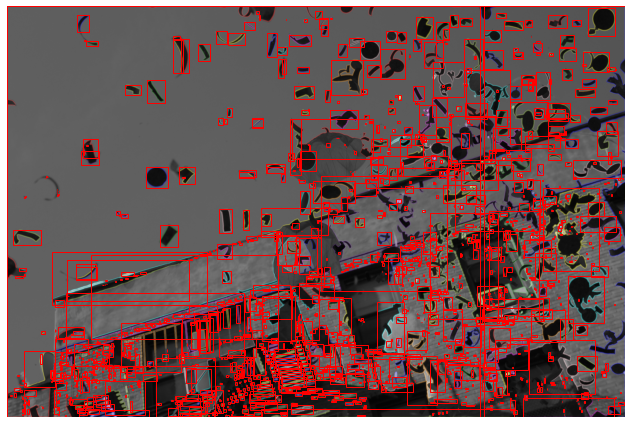

In [26]:
labeledImage, maxval = CCL(255*img_edge)
visualizeCells(labeledImage, img)

In [ ]:
regionprops(labeledImage)

# Testing Algorithm

### Load Image and Calculate Grad/Edges

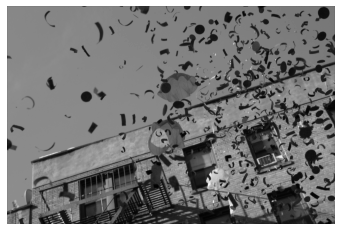

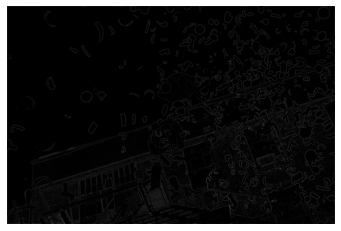

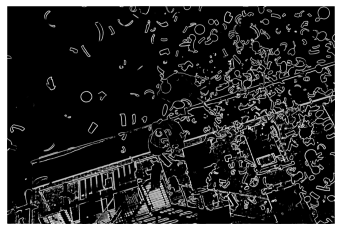

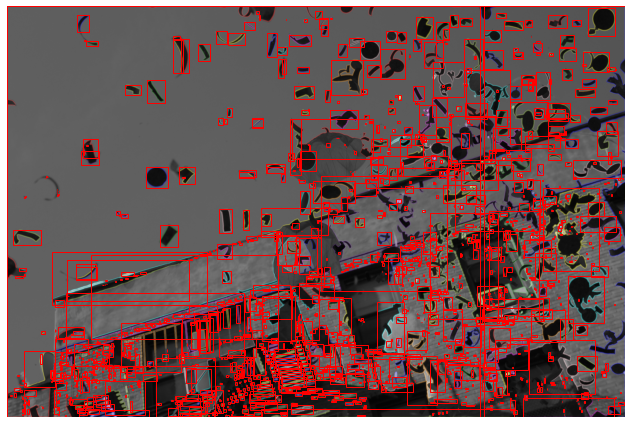

In [31]:
# img = cv2.imread('img0035.png', 0)
# img_clr = cv2.imread('img0035.png')
# img = cv2.imread('img0036.png', 0)
# img_clr = cv2.imread('img0036.png')
img = cv2.imread('img0037.png', 0)
img_clr = cv2.imread('img0037.png')
# plt.imshow(img, cmap='gray')
# plt.axis('off')
# plt.show()


gaussFilter = Gauss2D(5, 2, 5, 2)
img_G = convolve2d(img, gaussFilter, mode='same')
cv2.imwrite('img_G.png',img_G)
plt.imshow(img_G, cmap='gray')
plt.axis('off')
plt.show()

img_grad = gradMagnitude(img_G)
cv2.imwrite('img_grad.png',img_grad)
plt.imshow(img_grad, cmap='gray')
plt.axis('off')
plt.show()

img_grad = img_grad/img_grad.max()*255

img_edge, _ = thresholdAlgorithm(img_grad)
cv2.imwrite('img_edge.png',255*img_edge)
plt.imshow(img_edge, cmap='gray')
plt.axis('off')
plt.show()

labeledImage, _ = CCL(255*img_edge)
visualizeCells(labeledImage, img)

### Shared Functions

In [ ]:
def confettiRemoval(coords1,coords2,img,img_clr,img_grad,img_edge):
    r_min = min(coords1[1],coords2[1])
    r_max = max(coords1[1],coords2[1])
    c_min = min(coords1[0],coords2[0])
    c_max = max(coords1[0],coords2[0])
    PAD = 5

    img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
    img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

    ctr = 0
    thresholds = []
    while np.sum(img_edge_C) > 0:
        print('Iteration:', ctr+1)
        # area of interest
        img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
        img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
        img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
        img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

        visited = np.zeros(np.shape(img_edge_C))
        rows, cols = np.where(img_edge_C == 1)
        nodes = []
        for i in range(len(rows)):
            row, col = rows[i], cols[i]
            nodes.append((row,col))

        # up down, left right
        # directions = [(-1,0),(1,0),(0,-1),(0,1)]
        directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
        R = 5
        while len(nodes) > 0:
            # current edge coords
            row, col = nodes.pop(0)
            # only visit node if not visited before
            if visited[row, col] == 0:
                visited[row, col] = 1
                sum_k = []
                for d in directions:
                    curr_sum = 0
                    for r in range(R):
                        # curr_sum += np.abs(int(img_C[row,col])- 
                                        # int(img_C[row+d[0]*r,col+d[1]*r]))/255*(R-r+1)
                        # curr_sum += img_grad_C[row+d[0]*r,col+d[1]*r]

                        # calculate current position
                        r_pos = row+d[0]*r
                        c_pos = col+d[1]*r

                        # skip if current position is corner
                        if (c_pos) < 0 or (r_pos) < 0 or (c_pos) > (img_C.shape[1]-1) or  (r_pos) > (img_C.shape[0]-1):    
                            pass
                        else:
                            curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[r_pos,c_pos]))#/255*(R-r+1)
                    sum_k.append(curr_sum)
                
                # take max direction and value
                max_d = np.argmax(sum_k)

                best_dir = directions[max_d]
                # replace current pixel value with the new pixel value
                img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
                img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
                img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
                img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]
                # add node in that direction onto list
                # nodes.append((row-best_dir[0],col-best_dir[1]))
        
        # save current frame
        cv2.imwrite('frames/img_clr_C_{}.png'.format(ctr),img_clr_C)
        cv2.imwrite('frames/img_edge_C_{}.png'.format(ctr),255*img_edge_C)

        img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_C
        img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:] = img_clr_C
        img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_grad_C 
        img_G = convolve2d(img, gaussFilter, mode='same')
        img_grad = gradMagnitude(img_G)
        img_grad = img_grad/img_grad.max()*255
        img_edge, curr_threshold = thresholdAlgorithm(img_grad)
        thresholds.append(curr_threshold)

        # break from loop if over 10 iterations occurred and threshold is repeating:
        if ctr > 10:
            if thresholds[ctr] == thresholds[ctr-1] and thresholds[ctr] == thresholds[ctr-2] or ctr > 30:
                break
        ctr += 1


    # Generate Videos out of all the frames
    img_array = []

    for i in range(ctr):
        filename = 'frames/img_clr_C_{}.png'.format(i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)


    out = cv2.VideoWriter('videos/img_clr_C.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


    img_array = []

    for i in range(ctr):
        filename = 'frames/img_edge_C_{}.png'.format(i)
        img_temp = cv2.imread(filename)
        height, width, layers = img_temp.shape
        size = (width,height)
        img_array.append(img_temp)


    out = cv2.VideoWriter('videos/img_edge_C.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

    # return images
    return img,img_clr,img_grad,img_edge

In [ ]:
def plotFigures(coords1, coords2):
    r_min = min(coords1[1],coords2[1])
    r_max = max(coords1[1],coords2[1])
    c_min = min(coords1[0],coords2[0])
    c_max = max(coords1[0],coords2[0])
    PAD = 5

    # area of interest
    img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
    img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]


    plt.imshow(cv2.cvtColor(img_clr, cv2.COLOR_BGR2RGB))
    ax = plt.gca()
    rect = Rectangle((c_min,r_min),c_max-c_min,r_max-r_min,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
    plt.savefig('img_redbox.png', bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.imshow(img_edge, cmap='gray')
    ax = plt.gca()
    rect = Rectangle((c_min,r_min),c_max-c_min,r_max-r_min,linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
    plt.savefig('img_redbox_edge.png', bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))
    cv2.imwrite('img_clr_C.png',img_clr_C)
    plt.axis('off')
    plt.show()

    plt.imshow(img_C, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(img_edge_C, cmap='gray')
    cv2.imwrite('img_edge_C.png',255*img_edge_C)
    plt.axis('off')
    plt.show()

## Testing - Yellow Confetti piece

In [ ]:
coords1 = (556,419)
coords2 = (604,369)

r_min = min(coords1[1],coords2[1])
r_max = max(coords1[1],coords2[1])
c_min = min(coords1[0],coords2[0])
c_max = max(coords1[0],coords2[0])
PAD = 5

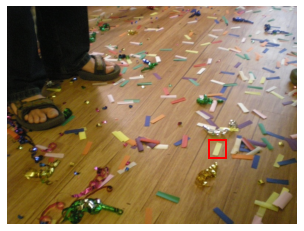

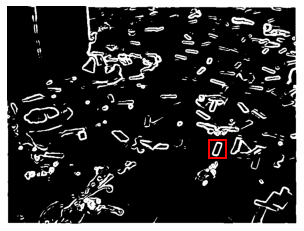

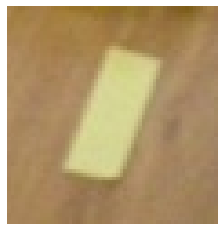

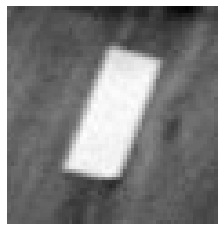

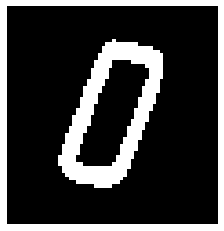

In [ ]:
plotFigures(coords1, coords2)

In [ ]:
img,img_clr,img_grad,img_edge = confettiRemoval(coords1,coords2,img,img_clr,img_grad,img_edge)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41


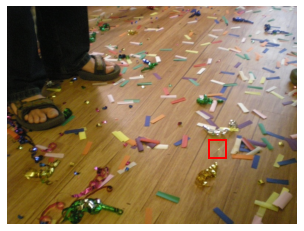

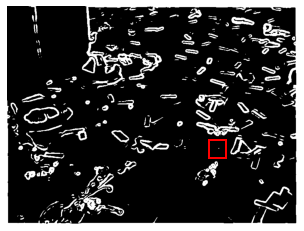

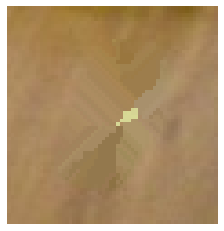

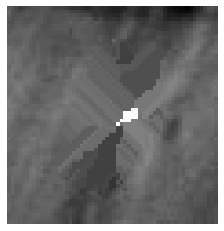

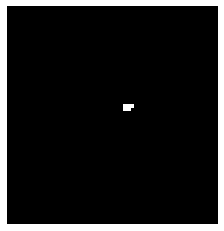

In [ ]:
plotFigures(coords1, coords2)

## Testing - Multiple Confetti pieces

In [ ]:
coords1 = (452,168)
coords2 = (535,114)

# coords1 = (422,273)
# coords2 = (480,241)
r_min = min(coords1[1],coords2[1])
r_max = max(coords1[1],coords2[1])
c_min = min(coords1[0],coords2[0])
c_max = max(coords1[0],coords2[0])
PAD = 5

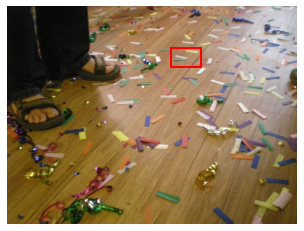

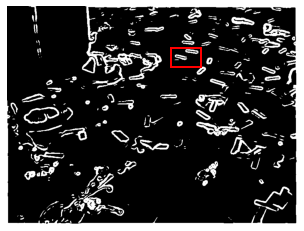

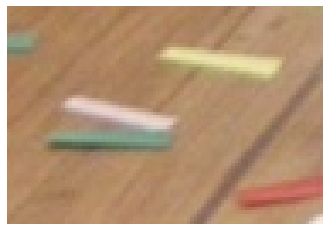

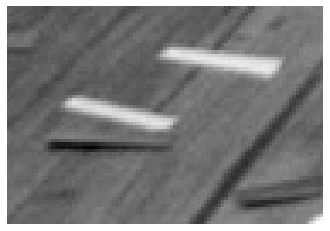

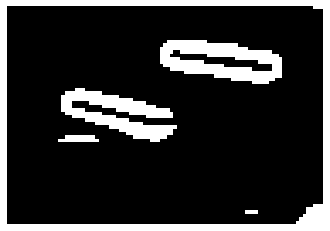

In [ ]:
plotFigures(coords1, coords2)

In [ ]:
img,img_clr,img_grad,img_edge = confettiRemoval(coords1,coords2,img,img_clr,img_grad,img_edge)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33


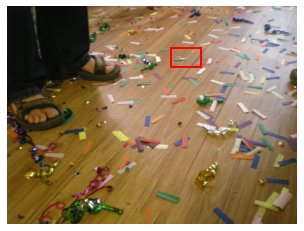

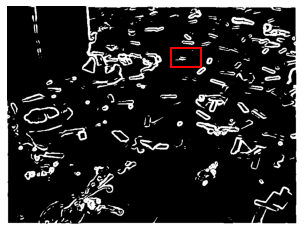

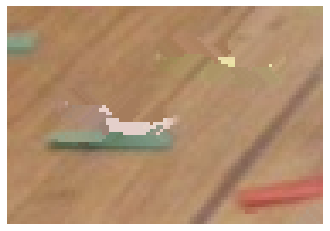

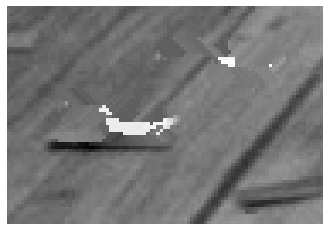

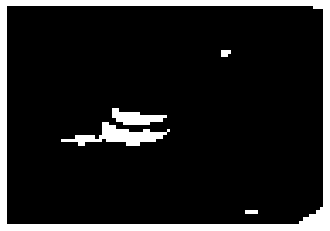

In [ ]:
plotFigures(coords1, coords2)

# Testing - test3.png

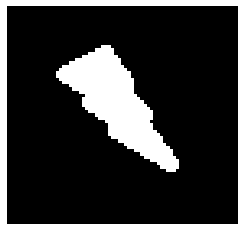

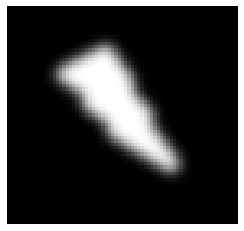

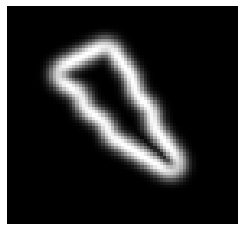

Loop iterations:  6
Threshold:  110.06818283441777


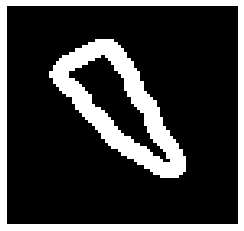

In [ ]:
img = cv2.imread('test3.png', 0)
img_clr = cv2.imread('test3.png')

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


gaussFilter = Gauss2D(5, 2, 5, 2)
# gaussFilter = Gauss2D(15, 4, 15, 4)
img_G = convolve2d(img, gaussFilter, mode='same')
plt.imshow(img_G, cmap='gray')
plt.axis('off')
plt.show()

img_grad = gradMagnitude(img_G)
plt.imshow(img_grad, cmap='gray')
plt.axis('off')
plt.show()

img_grad = img_grad/img_grad.max()*255

img_edge = thresholdAlgorithm(img_grad)
cv2.imwrite('img_edge.png',255*img_edge)
plt.imshow(img_edge, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
coords1 = (0+PAD,0+PAD)
coords2 = (img.shape[1]-PAD,img.shape[0]-PAD)
r_min = min(coords1[1],coords2[1])
r_max = max(coords1[1],coords2[1])
c_min = min(coords1[0],coords2[0])
c_max = max(coords1[0],coords2[0])
PAD = 5

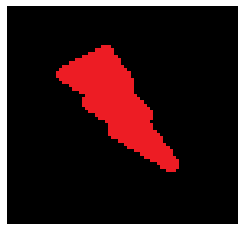

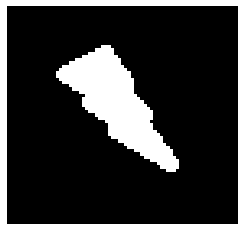

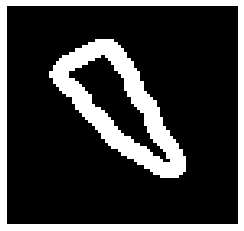

In [ ]:
# area of interest
img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

plt.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(img_C, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(img_edge_C, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

while np.sum(img_edge_C) > 0:
    # area of interest
    img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
    img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

    visited = np.zeros(np.shape(img_edge_C))
    rows, cols = np.where(img_edge_C == 1)
    nodes = []
    for i in range(len(rows)):
        row, col = rows[i], cols[i]
        nodes.append((row,col))

    # up down, left right
    directions = [(-1,0),(1,0),(0,-1),(0,1)]
    directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    R = 5
    while len(nodes) > 0:
        # current edge coords
        row, col = nodes.pop(0)
        # only visit node if not visited before
        if visited[row, col] == 0:
            visited[row, col] = 1
            sum_k = []
            for d in directions:
                curr_sum = 0
                for r in range(R):
                    # curr_sum += np.abs(int(img_C[row,col])- 
                                    # int(img_C[row+d[0]*r,col+d[1]*r]))/255*(R-r+1)
                    # curr_sum += img_grad_C[row+d[0]*r,col+d[1]*r]
                    curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[row+d[0]*r,col+d[1]*r]))#/255*(R-r+1)
                sum_k.append(curr_sum)
            
            # take max direction and value
            max_d = np.argmax(sum_k)
            # take min direction and value
            min_d = np.argmin(sum_k)

            best_dir = directions[max_d]
            # replace current pixel value with the new pixel value
            img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
            img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
            img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
            img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]
            # add node in that direction onto list
            # nodes.append((row-best_dir[0],col-best_dir[1]))

    img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_C
    img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:] = img_clr_C
    img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_grad_C 
    img_G = convolve2d(img, gaussFilter, mode='same')
    img_grad = gradMagnitude(img_G)
    img_grad = img_grad/img_grad.max()*255
    img_edge = thresholdAlgorithm(img_grad)

Loop iterations:  9
Threshold:  110.84942333148189
Loop iterations:  9
Threshold:  111.62021520520577
Loop iterations:  8
Threshold:  111.27388952014692
Loop iterations:  10
Threshold:  109.70766987689153
Loop iterations:  9
Threshold:  111.50989982516612
Loop iterations:  7
Threshold:  111.2063553860305
Loop iterations:  9
Threshold:  112.15552106950933
Loop iterations:  6
Threshold:  112.89101319763013
Loop iterations:  7
Threshold:  112.10437802984839
Loop iterations:  6
Threshold:  112.71199359704299
Loop iterations:  7
Threshold:  110.94842098764445
Loop iterations:  5
Threshold:  112.46981912768534
Loop iterations:  6
Threshold:  113.02031350073962
Loop iterations:  5
Threshold:  111.03121568049005
Loop iterations:  8
Threshold:  113.53096725519225
Loop iterations:  7
Threshold:  110.61176279415523
Loop iterations:  8
Threshold:  114.99564870020096
Loop iterations:  7
Threshold:  112.49784737047008
Loop iterations:  6
Threshold:  111.91676822054623
Loop iterations:  6
Threshold: 

KeyboardInterrupt: ignored

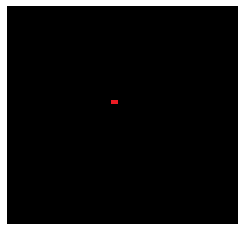

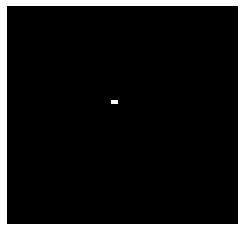

In [ ]:
# area of interest
img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

plt.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(img_C, cmap='gray')
plt.axis('off')
plt.show()

# Testing 2

In [ ]:
img = cv2.imread('img0036.png', 0)
img_clr = cv2.imread('img0036.png')
img_grad = gradMagnitude(img)
img_grad = img_grad/img_grad.max()*255
img_edge = thresholdAlgorithm(img_grad)

In [ ]:
# area of interest
img_C = img[360:425,550:610]
img_clr_C = img_clr[360:425,550:610,:]
img_grad_C = img_grad[360:425,550:610]
img_edge_C = img_edge[360:425,550:610]

visited = np.zeros(np.shape(img_edge_C))
rows, cols = np.where(img_edge_C == 1)
nodes = []
for i in range(len(rows)):
    row, col = rows[i], cols[i]
    nodes.append((row,col))

# up down, left right
directions = [(-1,0),(1,0),(0,-1),(0,1)]
# directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
R = 5
while len(nodes) > 0:
    # current edge coords
    row, col = nodes.pop(0)
    # only visit node if not visited before
    if visited[row, col] == 0:
        visited[row, col] = 1
        sum_k = []
        for d in directions:
            curr_sum = 0
            for r in range(R):
                # curr_sum += np.abs(int(img_C[row,col])- 
                                # int(img_C[row+d[0]*r,col+d[1]*r]))/255*(R-r+1)
                # curr_sum += img_grad_C[row+d[0]*r,col+d[1]*r]
                curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[row+d[0]*r,col+d[1]*r]))
            sum_k.append(curr_sum)
        
        # take max direction and value
        max_d = np.argmax(sum_k)
        # take min direction and value
        min_d = np.argmin(sum_k)

        best_dir = directions[max_d]
        # replace current pixel value with the new pixel value
        img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
        img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
        img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
        img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]
        # add node in that direction onto list
        # nodes.append((row-best_dir[0],col-best_dir[1]))

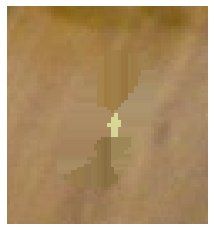

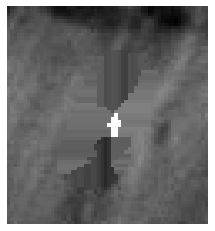

In [ ]:
plt.imshow(cv2.cvtColor(img_clr_C, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

plt.imshow(img_C, cmap='gray')
plt.axis('off')
plt.show()

Loop iterations:  18
Threshold:  31.730649566314245


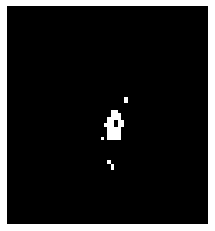

In [ ]:
img[360:425,550:610] = img_C
img_clr[360:425,550:610,:] = img_clr_C
img_grad[360:425,550:610] = img_grad_C 
img_grad = gradMagnitude(img)
img_grad = img_grad/img_grad.max()*255
img_edge = thresholdAlgorithm(img_grad)

img_C = img[360:425,550:610]
img_clr_C = img_clr[360:425,550:610,:]
img_grad_C = img_grad[360:425,550:610]
img_edge_C = img_edge[360:425,550:610]

plt.imshow(img_edge_C, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# area of interest
img_C = img[360:425,550:610]
img_clr_C = img_clr[360:425,550:610,:]
img_grad_C = img_grad[360:425,550:610]
img_edge_C = img_edge[360:425,550:610]

visited = np.zeros(np.shape(img_edge_C))
rows, cols = np.where(img_edge_C == 1)
nodes = []
for i in range(len(rows)):
    row, col = rows[i], cols[i]
    nodes.append((row,col))

# up down, left right
directions = [(-1,0),(1,0),(0,-1),(0,1)]

row, col = nodes[0]
sum_k = []
R = 2
for d in directions:
    curr_sum = 0
    for r in range(R):
        # curr_sum += np.abs(int(img_C[row,col])- 
                        # int(img_C[row+d[0]*r,col+d[1]*r]))/255*(R-r+1)
        # curr_sum += img_grad_C[row+d[0]*r,col+d[1]*r]
        curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[row+d[0]*r,col+d[1]*r]))
    sum_k.append(curr_sum)

# take max direction and value
max_d = np.argmax(sum_k)
# take min direction and value
min_d = np.argmin(sum_k)

best_dir = directions[max_d]

In [ ]:
plt.imshow(img_grad_C, cmap='gray')
# plt.plot(nodes[0][1],nodes[0][0],'rs')
# plt.plot(nodes[0][1]+best_dir[0],nodes[0][0]+best_dir[1],'rs')
plt.axis('off')
plt.show()

plt.imshow(img_edge_C, cmap='gray')
plt.plot(nodes[0][1],nodes[0][0i],'rs')
plt.plot(nodes[0][1]+best_dir[0],nodes[0][0]+best_dir[1],'rs')
plt.axis('off')
plt.show()


# Old Algorithm

In [ ]:
img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

ctr = 0
while np.sum(img_edge_C) > 0:
    # area of interest
    img_C = img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_clr_C = img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:]
    img_grad_C = img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]
    img_edge_C = img_edge[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD]

    visited = np.zeros(np.shape(img_edge_C))
    rows, cols = np.where(img_edge_C == 1)
    nodes = []
    for i in range(len(rows)):
        row, col = rows[i], cols[i]
        nodes.append((row,col))

    # up down, left right
    # directions = [(-1,0),(1,0),(0,-1),(0,1)]
    directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    R = 5
    while len(nodes) > 0:
        # current edge coords
        row, col = nodes.pop(0)
        # only visit node if not visited before
        if visited[row, col] == 0:
            visited[row, col] = 1
            sum_k = []
            for d in directions:
                curr_sum = 0
                for r in range(R):
                    # curr_sum += np.abs(int(img_C[row,col])- 
                                    # int(img_C[row+d[0]*r,col+d[1]*r]))/255*(R-r+1)
                    # curr_sum += img_grad_C[row+d[0]*r,col+d[1]*r]
                    curr_sum += np.abs(int(img_grad_C[row,col]) - int(img_grad_C[row+d[0]*r,col+d[1]*r]))#/255*(R-r+1)
                sum_k.append(curr_sum)
            
            # take max direction and value
            max_d = np.argmax(sum_k)
            # take min direction and value
            min_d = np.argmin(sum_k)

            best_dir = directions[max_d]
            # replace current pixel value with the new pixel value
            img_C[row,col] = img_C[row+best_dir[0],col+best_dir[1]]
            img_clr_C[row,col,0] = img_clr_C[row+best_dir[0],col+best_dir[1],0]
            img_clr_C[row,col,1] = img_clr_C[row+best_dir[0],col+best_dir[1],1]
            img_clr_C[row,col,2] = img_clr_C[row+best_dir[0],col+best_dir[1],2]
            # add node in that direction onto list
            # nodes.append((row-best_dir[0],col-best_dir[1]))
    
    # save current frame
    cv2.imwrite('frames/img_clr_C_{}.png'.format(ctr),img_clr_C)
    cv2.imwrite('frames/img_edge_C_{}.png'.format(ctr),255*img_edge_C)
    ctr += 1

    img[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_C
    img_clr[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD,:] = img_clr_C
    img_grad[r_min-PAD:r_max+PAD,c_min-PAD:c_max+PAD] = img_grad_C 
    img_G = convolve2d(img, gaussFilter, mode='same')
    img_grad = gradMagnitude(img_G)
    img_grad = img_grad/img_grad.max()*255
    img_edge = thresholdAlgorithm(img_grad)